In [1]:
!pip install --quiet vit-keras
!pip install tensorflow_addons

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(123)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools
import keras
from keras import backend as K
import tensorflow
from tensorflow.keras.layers import Dropout, Dense, LayerNormalization, Flatten
from tensorflow.keras.activations import gelu
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from vit_keras import vit
import tensorflow_addons as tfa
import math
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt
from zipfile import ZipFile
import time
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import  precision_score, recall_score, accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras import backend as K

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

Initializing the ViT Model

In [5]:
vit_model = vit.vit_b16(
        image_size = 224,
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        classes = 2)

347502902/347502902 [==============================] - 5s 0us/step


/opt/conda/lib/python3.10/site-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  warnings.warn(


Adding Additional layers on top of ViT Model

In [6]:
model = tensorflow.keras.Sequential([
    vit_model,
    Flatten(),
    Dense(128, activation=gelu),
    Dropout(0.1),
    LayerNormalization(epsilon=.000002),
    Dense(32, activation=gelu),
    Dropout(0.1),
    LayerNormalization(epsilon=.000002),
    Dense(2, activation='softmax')
], name='vision_transformer')

model.summary()

Model: "vision_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b16 (Functional)        (None, 768)               85798656  
                                                                 
 flatten (Flatten)           (None, 768)               0         
                                                                 
 dense (Dense)               (None, 128)               98432     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 layer_normalization (LayerN  (None, 128)              256       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 32)                4128      
                                                

In [7]:
#Compiling model using Binary Cross Entropy loss and Adam optimiser
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

Function for plotting the graph of Train and Validation Accuracy and loss

In [9]:
def graph_it(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(acc))

   #Plot Train and Validation Accuracy
  plt.plot(epochs, acc, 'r', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Model Accuracy: Training and Validation')
  plt.legend(loc=0)
  plt.figure()

  #Plot Train and Validation Loss
  plt.plot(epochs, loss, 'r', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation Loss')
  plt.legend(loc=0)
  plt.figure()


Function for Model Evaluation

In [10]:
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report, precision_score, roc_curve, ConfusionMatrixDisplay

def test_it(model, test_generator):
    test_labels = test_generator.classes

    predictions = model.predict(test_generator)
    predicted_labels = np.argmax(predictions, axis=1)

    cm = confusion_matrix(test_labels, predicted_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

    roc = roc_auc_score(test_labels, predictions[:, 1])  # Calculate ROC score

    # Calculate confusion matrix
    tn, fp, fn, tp = confusion_matrix(test_labels, predicted_labels).ravel()

    # Calculate sensitivity and specificity
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)

    report = classification_report(test_labels, predicted_labels) #Classification report

    precision = precision_score(test_labels, predicted_labels, average='weighted') #Calculate Precision score

    print("\n", report)
    print(f"Sensitivity: {round(sensitivity, 3)} Specificity: {round(specificity, 3)} Precision: {round(precision, 3)} ROC_AUC_SCORE: {round(roc, 3)}\n")

    # Plot AUC-ROC curve
    fpr, tpr, thresholds = roc_curve(test_labels, predictions[:, 1])
    plt.figure(figsize=(4, 4))
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc)
    plt.plot([0, 1], [0, 1], 'k--')  # Random guessing line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

In [11]:
# Set the directories for the data for task1 (SEB VS NEVUS)
train_dir = "/kaggle/input/isic-train-merge-aug/train_augumented-2023/train_augumented/task1"
test_dir = "/kaggle/input/isic-train-merge-aug/test2023/test/task1"
val_dir = "/kaggle/input/isic-train-merge-aug/val-2023/val/task1"

In [12]:
# Define the data generator
datagen = ImageDataGenerator(
    preprocessing_function= \
    tensorflow.keras.applications.mobilenet.preprocess_input)

image_size = (224, 224)
batch = 32

In [13]:
model_path = f'/content/drive/MyDrive/msc_project/model/{title}'
os.makedirs(model_path, exist_ok=True)

Creating batches to improve memory optimization

In [14]:
train_batches = datagen.flow_from_directory(train_dir,
                                            target_size=(image_size),
                                            batch_size=10)

valid_batches = datagen.flow_from_directory(val_dir,
                                            target_size=(image_size),
                                            batch_size=10)

# Note: shuffle=False causes the test dataset to not be shuffled
test_batches = datagen.flow_from_directory(test_dir,
                                            target_size=(image_size),
                                            batch_size=1,
                                            shuffle=False)

Found 12000 images belonging to 2 classes.
Found 150 images belonging to 2 classes.
Found 600 images belonging to 2 classes.


In [15]:
train_batches.class_indices

{'mel': 0, 'nevus_seb': 1}

In [16]:
valid_batches.class_indices

{'mel': 0, 'nevus_seb': 1}

In [17]:
from collections import Counter

class_counts = Counter(train_batches.classes)
print("Number of images per class:", class_counts)


Number of images per class: Counter({1: 9756, 0: 2244})


In [18]:
class_names = list(train_batches.class_indices.keys())
class_counts_with_names = {class_names[idx]: count for idx, count in class_counts.items()}
print("Number of images per class:", class_counts_with_names)

Number of images per class: {'mel': 2244, 'nevus_seb': 9756}


In [19]:
train_steps = np.ceil(train_batches.n / batch)
test_steps = np.ceil(test_batches.n / batch)
val_steps = np.ceil(valid_batches.n / batch)

Configuration of Early stopping criteria, learning rate

In [20]:
early_stopping = EarlyStopping(monitor='val_loss',patience=8)  #Configuring early stopping criteria

checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath = 'model.hdf5',
                                                  monitor = 'val_accuracy',
                                                  verbose = 1,
                                                  save_best_only = True,
                                                  save_weights_only = True,
                                                  mode = 'max')
#Configure dynamic learning rate
def step_decay(epoch):
    initial_lrate = 0.00002
    drop = 0.1
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(step_decay, verbose=1)

In [21]:
callbacks = [early_stopping, checkpointer, lr_scheduler]

Model Training

In [22]:
history = model.fit_generator(train_batches, steps_per_epoch=train_steps,
                              validation_data=valid_batches,
                              validation_steps=val_steps,
                              epochs=30,
                              callbacks=callbacks)

/tmp/ipykernel_24/1018363140.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_batches, steps_per_epoch=train_steps,



Epoch 1: LearningRateScheduler setting learning rate to 2e-05.
Epoch 1/30
375/375 [==============================] - ETA: 0s - loss: 0.4377 - accuracy: 0.8224
Epoch 1: val_accuracy improved from -inf to 0.88000, saving model to model.hdf5
375/375 [==============================] - 163s 284ms/step - loss: 0.4377 - accuracy: 0.8224 - val_loss: 0.3081 - val_accuracy: 0.8800 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 2e-05.
Epoch 2/30
375/375 [==============================] - ETA: 0s - loss: 0.3574 - accuracy: 0.8587
Epoch 2: val_accuracy did not improve from 0.88000
375/375 [==============================] - 103s 273ms/step - loss: 0.3574 - accuracy: 0.8587 - val_loss: 0.3792 - val_accuracy: 0.8600 - lr: 2.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 2e-05.
Epoch 3/30
375/375 [==============================] - ETA: 0s - loss: 0.2977 - accuracy: 0.8888
Epoch 3: val_accuracy did not improve from 0.88000
375/375 [=========================

In [23]:
# Compile the model
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

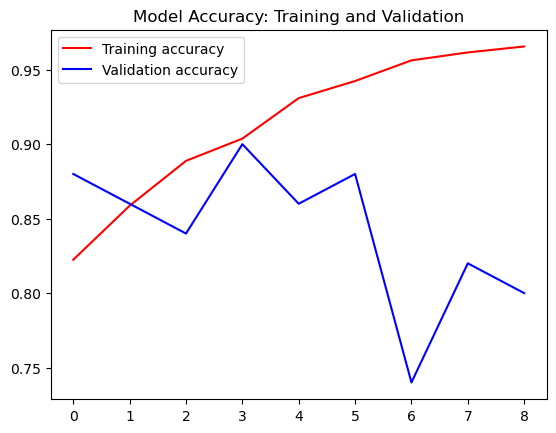

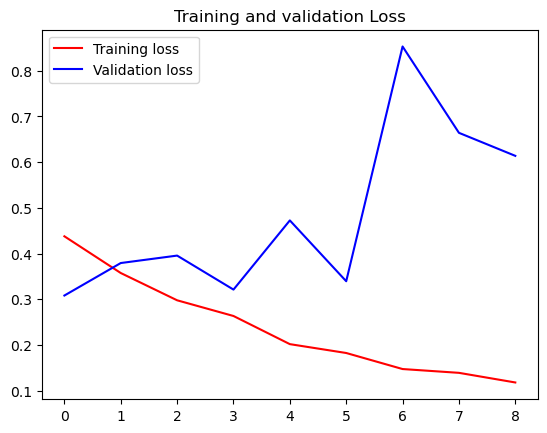

<Figure size 640x480 with 0 Axes>

In [24]:
graph_it(history)

**Model Evaluation using test data**

600/600 [==============================] - 22s 32ms/step


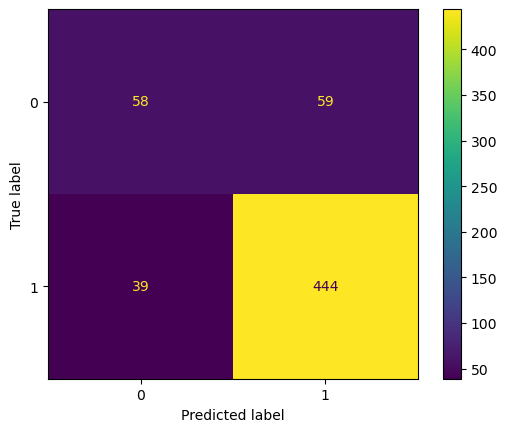


               precision    recall  f1-score   support

           0       0.60      0.50      0.54       117
           1       0.88      0.92      0.90       483

    accuracy                           0.84       600
   macro avg       0.74      0.71      0.72       600
weighted avg       0.83      0.84      0.83       600

Sensitivity: 0.919 Specificity: 0.496 Precision: 0.827 ROC_AUC_SCORE: 0.819



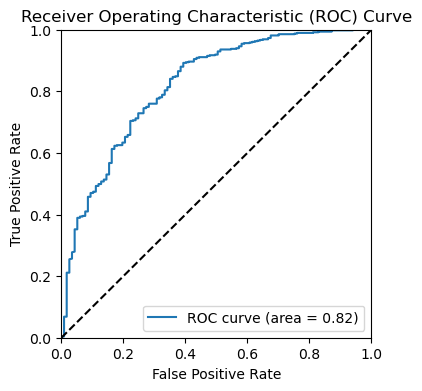

In [25]:
model.load_weights(filepath = 'model.hdf5')
test_it(model, test_batches)

In [26]:
from sklearn.metrics import confusion_matrix

predictions = model.predict_generator(test_batches, steps=len(test_batches), verbose=1)

y_pred = np.argmax(predictions, axis=1)
targetnames = ['mel','sb_nv']
y_true = test_batches.classes

cm1 = confusion_matrix(y_true,y_pred)
print('Confusion Matrix : \n', cm1)

total1=sum(sum(cm1))
#####from confusion matrix calculate accuracy
accuracy1=(cm1[0,0]+cm1[1,1])/total1
print ('Accuracy : ', accuracy1)

sensitivity1 = cm1[0,0]/(cm1[0,0]+cm1[1,0])
print('Sensitivity : ', sensitivity1 )

specificity1 = cm1[1,1]/(cm1[1,1]+cm1[0,1])
print('Specificity : ', specificity1)

  3/600 [..............................] - ETA: 18s

/tmp/ipykernel_24/1475839648.py:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(test_batches, steps=len(test_batches), verbose=1)


600/600 [==============================] - 20s 33ms/step
Confusion Matrix : 
 [[ 58  59]
 [ 39 444]]
Accuracy :  0.8366666666666667
Sensitivity :  0.5979381443298969
Specificity :  0.882703777335984
